# Tutorial: Peptide fragmentation spectrum intensity prediction

In bottom-up proteomics, a peptide fragmentation spectrum (MS2) is the most
central source of information to identify a peptide (and the original protein by
extend). In traditional peptide fragment spectrum identification workflows,
only the presence and location (x-axis) of peaks in the spectrum are used to 
identify the peptide that generated the spectrum. The intensity of these peaks
(y-axis) are, however, seldomly used in a comprehensive manner. At most,
traditional approaches naively assume that higher intensity is always better.
The lack of usage of peptide spectrum intensity patterns in the identification
step is mainly due to their complexity. The location of certain peaks (e.g., b-
and y-ions) are easily calculated based on their mass for any given peptide.
Their intensity, however, follows complex yet predictable patterns that cannot
be simply calculated. Nevertheless, they can be predicted with machine learning.

In this tutorial you will learn the basic steps in developing a machine learning
predictor for peptide fragmentation intensity prediction. The first chapter
handles the preparation and parsing of training data and the second chapter
first handles training a traditional machine learning model, and then a deep
learning model.

To avoid an overly complex tutorial, some aspects to intensity prediction are
simplified or not handled. For example, the resulting models will only be able
to predict singly charged b- and y-ions for unmodified peptides.

In [2]:
# Installing some required python packages
# ! pip install rich numpy pandas pyarrow matplotlib seaborn spectrum_utils==0.3.5 pyteomics sklearn hyperopt --quiet

## 1 Preparing training data

Training data for peptide fragmentation spectrum intensity prediction consists
of spectra that were already identified. The most convenient source of such
information are spectral libraries. These are datasets that were compiled from
a collection of mass spectrometry runs and usually consist of a single
representative spectrum for each peptide that was identified.

### 1.1 Finding spectral libraries

Many precompiled spectral libraries are available online. You can also generate
your own from a collection of proteomics experiments, using software such as
SpectraST.

Spectral libraries can be downloaded, for instance, from NIST, the
[US National Institute of Standards and Technology](https://chemdata.nist.gov/dokuwiki/doku.php?id=peptidew:cdownload)
. For this part of the practical, we will download the
[2020 Human HCD library of "best" tryptic spectra](https://chemdata.nist.gov/dokuwiki/doku.php?id=peptidew:lib:humanhcd20160503). For ease-of-use, we will download it in the text-based NIST MSP format.

The following code cell automatically downloads and extracts the spectral
library file using Linux commands. If you are working locally on a Windows
machine, you can download and extract the files manually.

_Note the exclamation marks in the code cell below, which allow us to run Linux commands, instead of Python._

In [3]:
# THIS CELL WORKS ONLY ON LINUX HOSTS (e.g. Google Colab)

# `wget` is a Linux command line tool to download files. 
! wget -q https://chemdata.nist.gov/download/peptide_library/libraries/human/HCD/2020_05_19/human_hcd_tryp_best.msp.tar.gz

# Next, we need to unpack the .tar.gz file
! tar -xf human_hcd_tryp_best.msp.tar.gz

'wget' is not recognized as an internal or external command,
operable program or batch file.
tar: Error opening archive: Failed to open 'human_hcd_tryp_best.msp.tar.gz'


Let's explore the MSP spectral library file, using the Linux `head` command:

In [4]:
! head human_hcd_tryp_best.msp

'head' is not recognized as an internal or external command,
operable program or batch file.


This shows the beginning of the first spectrum in the spectral library. Each spectrum entry consists of a header with identification data and metadata, and a peak list with three columns:

 - m/z values
 - intensity values
 - peak annotation info


 As the sequence of the first peptide is `AAAAAAAAAAAAAAAGAGAGAK`, we can assume that this library is ordered alphabetically. You can read through the file to verify this assumption. This ordering will be important later on.


### 1.2 Parsing the MSP spectral library file

[Pyteomics](https://pyteomics.readthedocs.io/) is a Python package for proteomics that contains readers for many proteomics-related file formats. Unfortunately, MSP is not one of them. So first, we need a custom MSP reader function.

In [5]:
from rich import print, progress  # Rich is a pretty cool library. Google it ;)
import numpy as np
import pandas as pd

This function iterates over each line in the MSP file. Once it has gathered all information for a single spectrum, it uses `yield` to return a dictionary. This means that we can iterate over the function using a `for` loop, and process spectra one-by-one. 

_If you do not fully understand the function, no problem! This is not the important part of the tutorial_ 😉

In [6]:
def read_msp(filename):
    """Iterate over MSP spectral library file and return spectra as dicts."""
    spectrum = {}
    mz = []
    intensity = []
    annotation = []

    for line in open(filename, "rt"):
        # `Name: ` is the first line of a new entry in the file
        if line.startswith("Name: "):
            if spectrum:
                # Finalize and yield previous spectrum
                spectrum["sequence"] = spectrum["Fullname"].split(".")[1]  # Remove the previous/next amino acids
                spectrum["mz"] = np.array(mz, dtype="float32")
                spectrum["intensity"] = np.array(intensity, dtype="float32")
                spectrum["annotation"] = np.array(annotation, dtype="str")
                yield spectrum

                # Define new spectrum
                spectrum = {}
                mz = []
                intensity = []
                annotation = []
            
            # Extract everything after `Name: `
            spectrum["Name"] = line.strip()[6:]

        elif line.startswith("Comment: "):
            # Parse all comment items as metadata
            metadata = [i.split("=") for i in line[9:].split(" ")]
            for item in metadata:
                if len(item) == 2:
                    spectrum[item[0]] = item[1]

        elif line.startswith("Num peaks: "):
            spectrum["Num peaks"] = int(line.strip()[11:])

        elif len(line.split("\t")) == 3:
            # Parse peak list items one-by-one
            line = line.strip().split("\t")
            mz.append(line[0])
            intensity.append(line[1])
            annotation.append(line[2].strip('"'))

    # Final spectrum
    spectrum["sequence"] = spectrum["Fullname"].split(".")[1]  # Remove the previous/next amino acids
    spectrum["mz"] = np.array(mz, dtype="float32")
    spectrum["intensity"] = np.array(intensity, dtype="float32")
    spectrum["annotation"] = np.array(annotation, dtype="str")
    yield spectrum

Let's explore the first spectrum:

In [7]:
# break allows us to only stop after the first spectrum is defined
for spectrum in read_msp("human_hcd_tryp_best.msp"):
    print(spectrum["Name"])
    break


AAAAAAAAAAAAAAAGAGAGAK/2_0

We can format the peak list as a Pandas DataFrame:

In [8]:
pd.DataFrame({
    "mz": spectrum["mz"],
    "intensity": spectrum["intensity"],
    "annotation": spectrum["annotation"],
})

,mz,intensity,annotation
0,110.071198,259243.203125,? 143/200
1,115.086403,97764.398438,a2/-1.6ppm 145/200
2,116.070396,26069.500000,? 80/200
3,120.080597,208924.406250,? 148/200
4,129.065704,25535.900391,"Int/AG/-1.2ppm,Int/GA/-1.2ppm 86/200"
...,...,...,...
112,1170.621338,442693.312500,y16/-1.1ppm 180/200
113,1171.624146,173247.703125,y16+i/-1.0ppm 133/200
114,1241.657959,264065.593750,y17/-1.3ppm 170/200
115,1242.660156,112235.101562,y17+i/-1.8ppm 125/200


The left-most column denotes the peak annotation. This tells us which ion generated the peak, according to the search engine or library generation software. Note that many peaks — highlighted with a question mark — are not annotated, even though the spectrum was confidently identified.

Using the Python package [spectrum_utils](https://spectrum-utils.readthedocs.io/), we can easily visualize the spectrum:


In [9]:
import matplotlib.pyplot as plt

import spectrum_utils.spectrum as sus
import spectrum_utils.plot as sup

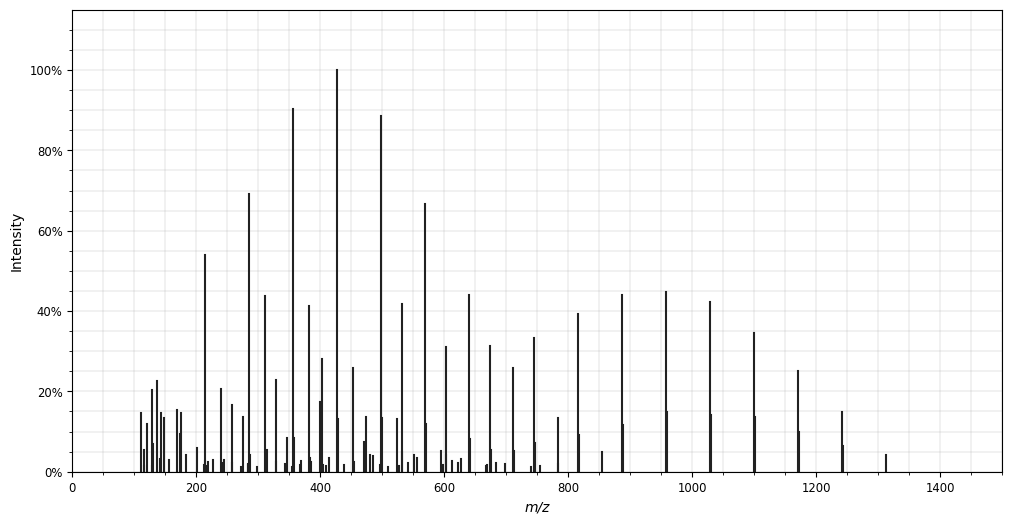

In [10]:
plt.figure(figsize=(12,6))
sup.spectrum(
    sus.MsmsSpectrum(
        identifier=spectrum["Name"],
        precursor_mz=float(spectrum["Parent"]),
        precursor_charge=int(spectrum["Charge"]),
        mz=spectrum["mz"],
        intensity=spectrum["intensity"]
    )
)
plt.show()

### 1.3 Preparing spectra for training

To use a peptide fragmentation spectrum such as this one as training _target_ for a machine learning model, it needs some preparation and parsing. Usually this comprises of the following steps:

1. Normalize the intensities
2. Transform the intensities
3. Annotate the peaks
4. Parse the relevant peak intensities to an format suitable for machine learning

For each of these steps, we will write a function that can be reused later on in
the tutorial.

#### 1.3.1 Normalize the intensities

Depending on the file format, peak intensities can range from 0 to 1, from 0 to 100, from 0 from 10 000... Machine learning algorithms require the target (and feature) values to be normalized in a specific range. For fragmentation spectra, there are two common options: total ion current (TIC) normalization and base peak normalization. For the former, all intensity values are divided by the total sum of all intensity values in the spectrum. The sum of all normalized intensities will be `1`. For the latter, all intensity values are divided by the most intense peak in the spectrum, resulting in that peak to have normalized intensity  `1`. Here we will implement TIC-normalization.

In [11]:
def tic_normalize(msp_spectrum):
    tic = np.sum(msp_spectrum["intensity"])
    msp_spectrum["intensity"] = msp_spectrum["intensity"] / tic
    return msp_spectrum

In [12]:
# Before normalization
spectrum["intensity"][:10]

array([259243.2,  97764.4,  26069.5, 208924.4,  25535.9, 361336.8,
       120990.5, 401263.5,  54146.8, 259764.2], dtype=float32)

In [13]:
spectrum = tic_normalize(spectrum)

# After normalization
spectrum["intensity"][:10]

array([0.00882945, 0.00332971, 0.00088789, 0.00711566, 0.00086972,
       0.0123066 , 0.00412076, 0.01366645, 0.00184416, 0.00884719],
      dtype=float32)

#### 1.3.2 Transform the intensities

The distribution of peak intensities shows us that most peptide fragmentation peaks have a relatively low intensity, while only a few peaks are more intense:

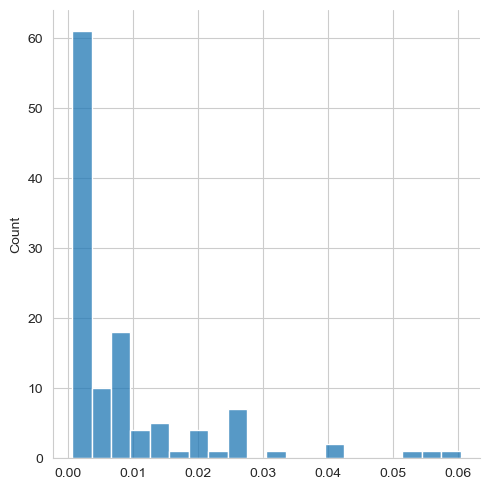

In [14]:
import seaborn as sns
sns.set_style("whitegrid")

# Before transform
sns.displot(spectrum["intensity"], bins=20)
plt.show()

To make the intensities follow a more linear distribution — which is better for machine learning algorithms — we can transform the intensity values. Two methods are often used:
square root-tranform, and log-transform. While both methods mostly have the same effect, we will here opt for square root transform, as log-transform results in negative values, which can be cumbersome to deal with.

In [15]:
def sqrt_transform(msp_spectrum):
    msp_spectrum["intensity"] = np.sqrt(msp_spectrum["intensity"])
    return msp_spectrum

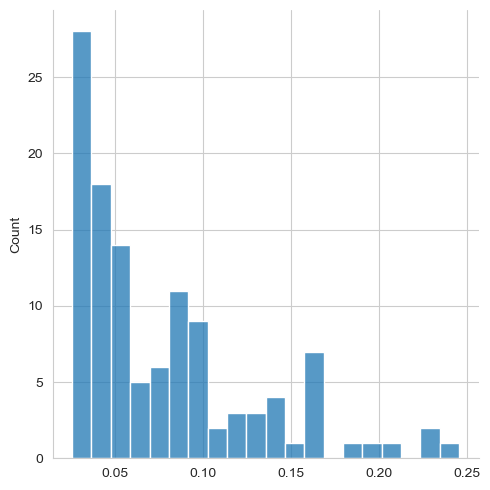

In [16]:
spectrum = sqrt_transform(spectrum)

# After transform
sns.displot(spectrum["intensity"], bins=20)
plt.show()

#### 1.3.3 Annotate the peaks

With the NIST spectral libraries, this step is pretty easy, as peak annotations are already present. If this would not be the case, we can make use of 
spectrum_utils, which can annotate peaks given the peptide _sequence_ and any _modifications_. See the [spectrum_utils documentation](https://spectrum-utils.readthedocs.io/en/latest/processing.html#peak-annotations) for more info.

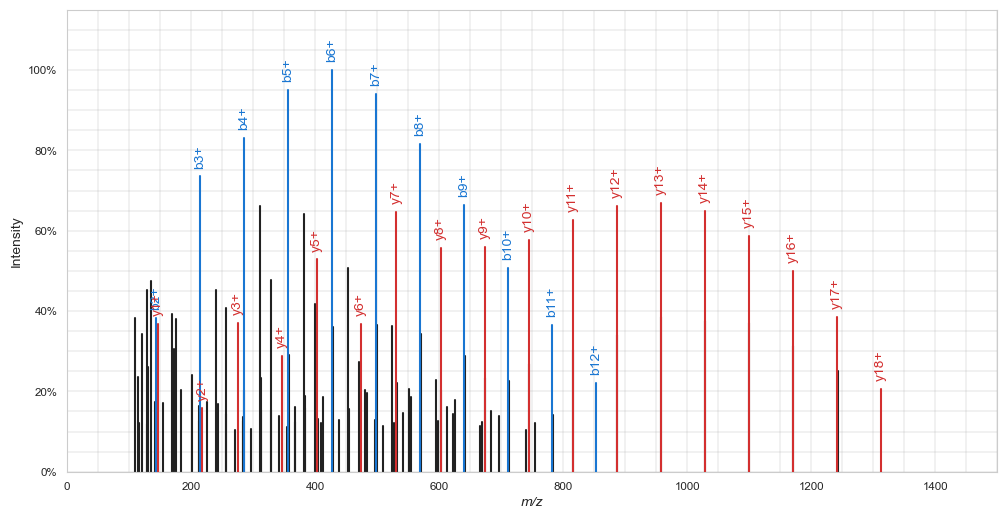

In [17]:
plt.figure(figsize=(12,6))
sup.spectrum(
    sus.MsmsSpectrum(
        identifier=spectrum["Name"],
        precursor_mz=float(spectrum["Parent"]),
        precursor_charge=int(spectrum["Charge"]),
        mz=spectrum["mz"],
        intensity=spectrum["intensity"],
        peptide=spectrum["sequence"],
    ).annotate_peptide_fragments(25, "ppm")
)
plt.show()

#### 1.3.4 Parse the relevant peak intensities to an format suitable for machine learning

Note in the visualization above that spectrum_utils only annotated b- and y-ions, while in the MSP file many other ion types are also annotated. For simplicity's sake, in this tutorial we will train a model to only predict singly charged b- and y-ions. 

Let's filter the spectrum for only those peaks. This can be done with regular
expressions (regex) and numpy. TIP: [regex101.com](https://regex101.com)  is a great website for building and testing regular expressions. The regex
`^(b|y)([0-9]+)\/` only matches peak annotations for singly charged b- and
y-ions. You can investigate it at https://regex101.com/r/bgZ7EG/1.

In the following function, `numpy.vectorize` is used. What does it do and why do we use it here?

In [18]:
import re

def filter_peaks(msp_spectrum):
    """Filter spectrum peaks to only charge 1 b- and y ions."""
    # Generate the boolean mask
    get_mask = np.vectorize(lambda x: bool(re.match("^(b|y)([0-9]+)\/", x)))
    mask = get_mask(msp_spectrum["annotation"])
    
    # Apply the mask to each peak array
    msp_spectrum["annotation"] = msp_spectrum["annotation"][mask]
    msp_spectrum["mz"] = msp_spectrum["mz"][mask]
    msp_spectrum["intensity"] = msp_spectrum["intensity"][mask]

    return msp_spectrum

spectrum = filter_peaks(spectrum)

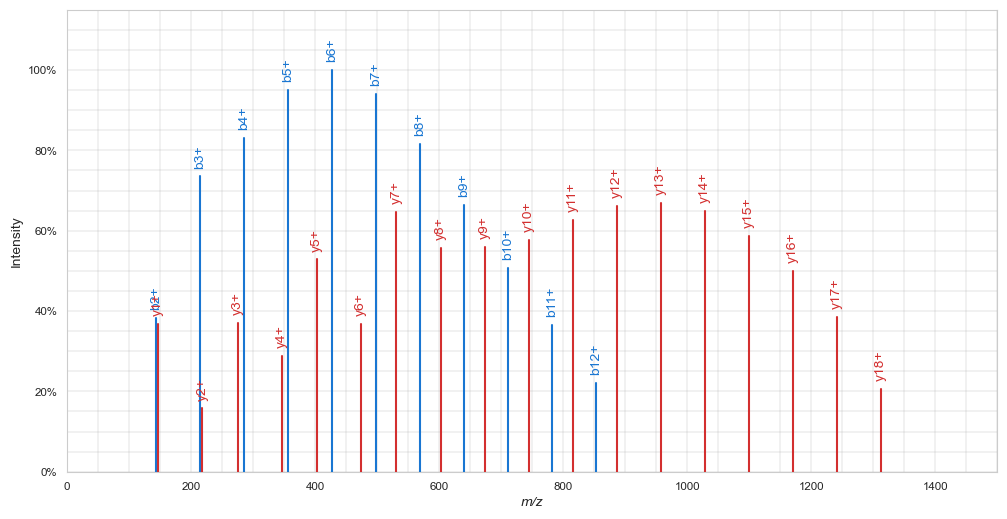

In [19]:
plt.figure(figsize=(12,6))
sup.spectrum(
    sus.MsmsSpectrum(
        identifier=spectrum["Name"],
        precursor_mz=float(spectrum["Parent"]),
        precursor_charge=int(spectrum["Charge"]),
        mz=spectrum["mz"],
        intensity=spectrum["intensity"],
        peptide=spectrum["sequence"]
    ).annotate_peptide_fragments(25, "ppm")
)
plt.show()

Now, the spectrum indeed only contains singly charged b- and y-ions. Note the nice gausian-like distributions of equally-distanced b- and y-ions. This is a feature specific for this peptide spectrum. Can you guess why? Tip: Take a look at the peptide sequence.

Currently, all peaks are listed together in single numpy arrays, sorted by m/z values. For training a machine learning model, we need the intensity values in a more suitable structure. As we are planning to only predict simple singly charged b- and y-ions, we can create two arrays — one for each ion type — with the ions sorted by ion number:

```python
parsed_intensity = {
    "b": [b1, b2, b3, b4 ... bN],
    "y": [y1, y2, y3, y4 ... yN]
}
```


where N is the total number of possible fragments for that peptide sequence. Quick question: What value will N have for our peptide with sequence `AAAAAAAAAAAAAAAGAGAGAK`?

The following function builds upon the `filter_peaks` function to not only filter the correct ion types, but also order them properly:


In [20]:
def parse_peaks(msp_spectrum, ion_type):
    # Generate vectorized functions
    get_ions = np.vectorize(lambda x: bool(re.match(f"^({ion_type})([0-9]+)\/", x)))
    get_ion_order = np.vectorize(lambda x: re.match(f"^({ion_type})([0-9]+)\/", x)[2])

    # Get mask with requested ion types
    mask = get_ions(msp_spectrum["annotation"])

    # Create empty array with for all possible ions
    n_ions = len(msp_spectrum["sequence"]) - 1
    parsed_intensity = np.zeros(n_ions)

    # Check if any ions of this type are present
    if mask.any():
        # Filter for ion type and sort
        ion_order = get_ion_order(msp_spectrum["annotation"][mask]).astype(int) - 1
        # Add ions to correct positions in new array
        parsed_intensity[ion_order] = msp_spectrum["intensity"][mask]

    try:
        msp_spectrum["parsed_intensity"][ion_type] = parsed_intensity
    except KeyError:
        msp_spectrum["parsed_intensity"] = {}
        msp_spectrum["parsed_intensity"][ion_type] = parsed_intensity
    
    return msp_spectrum

spectrum = parse_peaks(spectrum, "b")
spectrum = parse_peaks(spectrum, "y")

In [21]:
spectrum['parsed_intensity']

{'b': array([0.        , 0.0940595 , 0.18064232, 0.20420307, 0.23347196,
        0.2457854 , 0.23112106, 0.20064339, 0.16306745, 0.1246587 ,
        0.08999325, 0.05416884, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 'y': array([0.09027135, 0.03876459, 0.09092397, 0.07086667, 0.1299265 ,
        0.09038813, 0.15890096, 0.13701038, 0.13768263, 0.14171469,
        0.15388304, 0.16281605, 0.16425258, 0.15970773, 0.1443574 ,
        0.12279043, 0.09483507, 0.05047642, 0.        , 0.        ,
        0.        ])}

Great! These values are now ready to be used as prediction targets for a machine learning algorithm.

### 1.4 Parse the full spectral library

Now that all functions for spectrum preparation are written, we can parse the full spectral library. Let's first explore some of the basic statistics of this
library.

#### 1.4.1 Exploring basic spectral library statistics

##### Total number of spectra

This one is easy, we quickly scan the number of lines starting with `Name: ` in the file:

In [22]:
def msp_count_spectra(filename):
    """Count number of spectra in MSP file."""
    count = 0
    for line in open(filename, "rt"):
        if line.startswith("Name: "):
            count += 1
    return count

n_spectra = msp_count_spectra("human_hcd_tryp_best.msp")
print(n_spectra)

398373

For more statistics, we will have to read the full library. One advantage we have now, is that knowing the total number of spectra allows us to track the progress of reading the full MSP file (`progress.track`). To limit the amount of data we keep in memory (this full MSP file is almost 2GB!), we can process the intensity values of each spectrum while parsing and only keep the parsed data:

In [23]:
spectrum_list = []
for msp_spectrum in progress.track(
    read_msp("human_hcd_tryp_best.msp"),
    total=n_spectra,
    description="Parsing  MSP file..."
):
    # Process intensities
    msp_spectrum = tic_normalize(msp_spectrum)
    msp_spectrum = sqrt_transform(msp_spectrum)
    msp_spectrum = parse_peaks(msp_spectrum, "b")  # Adds `parsed_intensity` > `b`
    msp_spectrum = parse_peaks(msp_spectrum, "y")  # Adds `parsed_intensity` > `y`

    # Parse metadata
    spectrum = {
        "sequence": msp_spectrum["sequence"],
        "modifications": msp_spectrum["Mods"],
        "charge": int(msp_spectrum["Charge"]),
        "nce": float(msp_spectrum["NCE"]),
        "parsed_intensity": msp_spectrum["parsed_intensity"]
    }

    # Append to list
    spectrum_list.append(spectrum)

c:\Users\ralfg\miniconda3\envs\proteomicsml\lib\site-packages\rich\live.py:229: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Generating a Pandas DataFrame from the list of spectrum dictionaries, allows us to easily explore the full dataset:

In [24]:
spectrum_df = pd.DataFrame(spectrum_list)
spectrum_df

,sequence,modifications,charge,nce,parsed_intensity
0,AAAAAAAAAAAAAAAGAGAGAK,0,2,29.43,"{'b': [0.0, 0.09405950456857681, 0.18064232170..."
1,AAAAAAAAAAAAAAAGAGAGAK,0,3,29.22,"{'b': [0.0, 0.21546243131160736, 0.21998108923..."
2,AAAAAAAAAAAPPAPPEGASPGDSAR,0,2,27.80,"{'b': [0.0, 0.0, 0.056045547127723694, 0.10302..."
3,AAAAAAAAAAAPPAPPEGASPGDSAR,0,3,30.00,"{'b': [0.0, 0.04407356679439545, 0.07545641809..."
4,AAAAAAAAAASGAAIPPLIPPR,0,3,0.00,"{'b': [0.0, 0.10330961644649506, 0.15637055039..."
...,...,...,...,...,...
398368,YYYYHR,0,2,30.20,"{'b': [0.0, 0.14489535987377167, 0.0, 0.0, 0.0..."
398369,YYYYHR,0,3,37.52,"{'b': [0.018267542123794556, 0.076188296079635..."
398370,YYYYMWK,0,2,31.00,"{'b': [0.0, 0.22406582534313202, 0.11588517576..."
398371,YYYYMWK,"1(4,M,Oxidation)",2,30.00,"{'b': [0.0, 0.14110229909420013, 0.0, 0.0, 0.0..."


Making a Pandas DataFrame out of `spectrum_list` is so simple because it is a 
list of consistent dictionaries. 

##### Precursor charge state

A different precursor charge state can heavily alter peptide fragmentation. It is therefore important to have a representative amount of peptide spectra for each charge state in the spectral library.

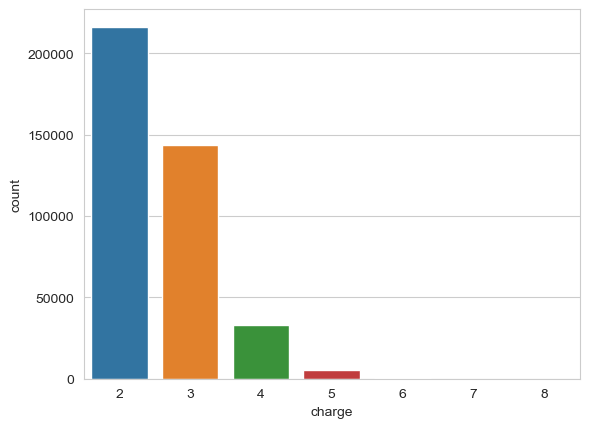

In [25]:
sns.countplot(data=spectrum_df, x="charge")
plt.show()

##### Peptide length

Idem for the length of the peptide sequence. It usually makes sense to filter 
the train dataset for peptides within a certain length range.

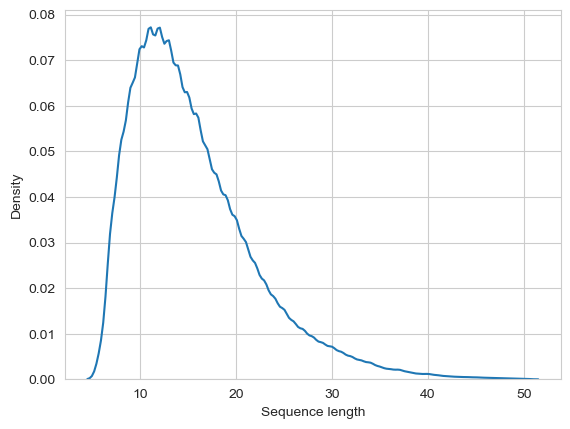

In [26]:
sns.kdeplot(spectrum_df["sequence"].str.len())
plt.xlabel("Sequence length")
plt.show()

In [27]:
spectrum_df["sequence"].str.len().describe()

count    398373.000000
mean         15.541467
std           6.506968
min           6.000000
25%          11.000000
50%          14.000000
75%          19.000000
max          50.000000
Name: sequence, dtype: float64

In [28]:
(spectrum_df["sequence"].str.len() > 35).value_counts()

False    393429
True       4944
Name: sequence, dtype: int64

For this dataset, the minimum peptide length is 6, while the maximum is 50.
Nevertheless, only 

##### Peptide modifications

Likewise, peptide modifications can influence peptide fragmentation. How many of the spectra in our library come from modified peptides?

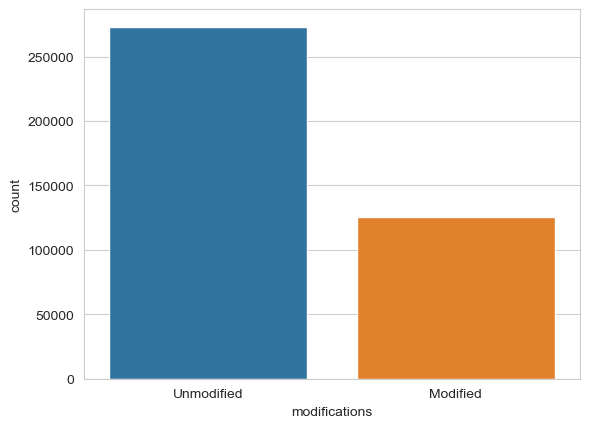

In [29]:
modification_state = (spectrum_df["modifications"] == "0").map({True: "Unmodified", False: "Modified"})
sns.countplot(x=modification_state)
plt.show()

##### Collision energy

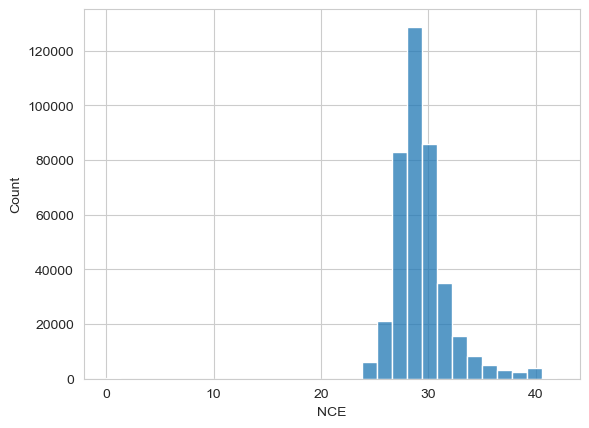

In [30]:
sns.histplot(spectrum_df["nce"], bins=30)
plt.xlabel("NCE")
plt.show()

Note the range of the x-axis, which was automatically chosen by the plotting library. It seems to start at 0, which indicates that some values are very low...

In [31]:
(spectrum_df["nce"] == 0.0).value_counts()

False    398103
True        270
Name: nce, dtype: int64

Indeed, it seems that some peptide spectra have collision energy (CE) `0`, which most likely means that the true collision energy setting is not known. We can either opt to not use CE as a feature for training, or to remove these spectra from the dataset. Including these values would introduce unwanted noise in the training data.

##### Duplicate entries?

An important aspect to compiling training data for machine learning is whether or not entries are duplicated. With spectral libraries, matters are complicated by multiple levels of "uniqueness":

- Peptide level: Unique sequence
- Peptidoform level: Unique sequence & modifications
- Precursor level: Unique sequence & modifications & charge

More parameters can be included for "uniqueness", such as instrument and acquisition properties: CE, fragmentation method (beam-type CID ("HCD"), trap-type CID, ETD, EAD...), acquisition method (Orbitrap, ion trap, TOF...). In this tutorial, we are using only HCD Orbitrap data, which makes things a bit simpler. Nevertheless, this will impact the application domain of the final models.

In [32]:
counts = pd.DataFrame({
    "Level": [
        "Full library",
        "Precursor",
        "Peptidoform",
        "Peptide",
    ],
    "Count": [
        spectrum_df.shape[0],
        spectrum_df[["sequence", "modifications", "charge"]].drop_duplicates().shape[0],
        spectrum_df[["sequence", "modifications"]].drop_duplicates().shape[0],
        spectrum_df["sequence"].unique().shape[0],
    ],
})

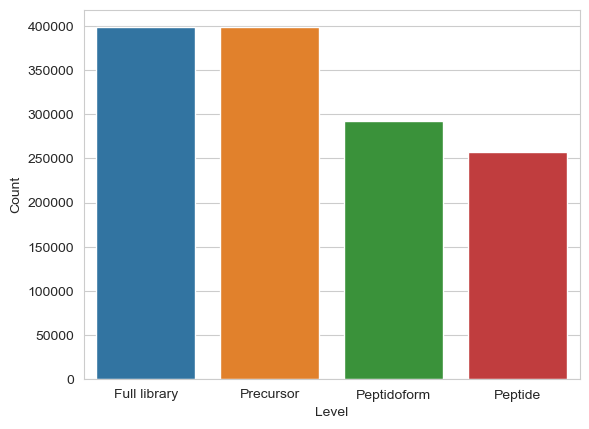

In [33]:
sns.barplot(data=counts, x="Level", y="Count")
plt.show()

In [34]:
counts

,Level,Count
0,Full library,398373
1,Precursor,398373
2,Peptidoform,292061
3,Peptide,257202


Seems like this library was filtered for uniqueness on the precursor level.

#### 1.4.1 Selecting data

For selecting training data, we will apply some additional filters:

- While plain amino acid sequences are straightforward to encode, peptide modifications complicate matters. For simplicity's sake, we will therefore not open the "can of modifications" in this tutorial.
- As we might want to use CE as a feature, we can remove the small amount of entries that are missing the a CE value
- To make the training task a bit less complex, we can limit peptide length to 35. Although the maximum peptide length in this library is 50, only 4944 spectra have a peptide length of over 35.

In [35]:
spectrum_df = spectrum_df[
    (modification_state == "Unmodified") &
    (spectrum_df["sequence"].str.len() <= 35) &
    (spectrum_df["nce"] != 0)
]

Let's see how many spectra we retained:

In [36]:
spectrum_df.shape[0]

270440

In [52]:
spectrum

{'sequence': 'YYYYWHLR',
 'modifications': '0',
 'charge': 3,
 'nce': 36.22,
 'parsed_intensity': {'b': array([0.        , 0.08866303, 0.        , 0.        , 0.        ,
         0.        , 0.        ]),
  'y': array([0.16996175, 0.12056533, 0.16980277, 0.20397678, 0.18093778,
         0.09508998, 0.        ])}}

#### 1.4.2 Train / validation / test split

Now that we have our data, we can filter it to a final set for training and validation and a final set for testing. A small reminder of what these terms mean:

- Training data: For training the model
- Validation data: For validating the model while optimizing hyperparameters
- Testing data: For final testing of model that was trained with the best hyperparameters (according to the validation data), right before deployment

The testing data cannot be used until a final model is trained, and serves as a last test before deployment. It should not be used before a final model is selected.

In [37]:
from sklearn.model_selection import train_test_split

np.random.seed()  # Why is this needed?

train_val_peptides, test_peptides = train_test_split(spectrum_df["sequence"].unique(), train_size=0.9)
train_val_spectra = spectrum_df[spectrum_df["sequence"].isin(train_val_peptides)]
test_spectra = spectrum_df[spectrum_df["sequence"].isin(test_peptides)]

Question: Why do we not apply `train_test_split()` directly on `spectrum_df`, but instead on `spectrum_df["sequence"].unique()`?

###  2 Training machine learning models for peptide fragmentation

#### 2.1 A traditional machine learning approach

##### 2.1.1 Feature engineering

In [38]:
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
aa_properties = {
    "basicity": np.array([37,35,59,129,94,0,210,81,191,81,106,101,117,115,343,49,90,60,134,104]),
    "helicity": np.array([68,23,33,29,70,58,41,73,32,73,66,38,0,40,39,44,53,71,51,55]),
    "hydrophobicity": np.array([51,75,25,35,100,16,3,94,0,94,82,12,0,22,22,21,39,80,98,70]),
    "pI": np.array([32,23,0,4,27,32,48,32,69,32,29,26,35,28,79,29,28,31,31,28]),
}

properties_df = pd.DataFrame(aa_properties, index=amino_acids)
properties_df

,basicity,helicity,hydrophobicity,pI
A,37,68,51,32
C,35,23,75,23
D,59,33,25,0
E,129,29,35,4
F,94,70,100,27
G,0,58,16,32
H,210,41,3,48
I,81,73,94,32
K,191,32,0,69
L,81,73,94,32


In [42]:
# Peptide input
# Feature engineering settings

properties = np.array([
    [37,35,59,129,94,0,210,81,191,81,106,101,117,115,343,49,90,60,134,104],  # basicity
    [68,23,33,29,70,58,41,73,32,73,66,38,0,40,39,44,53,71,51,55],  # helicity
    [51,75,25,35,100,16,3,94,0,94,82,12,0,22,22,21,39,80,98,70],  # hydrophobicity
    [32,23,0,4,27,32,48,32,69,32,29,26,35,28,79,29,28,31,31,28],  # pI
])

quantiles = [0, 0.25, 0.5, 0.75, 1]
aa_indices = {aa: i for i, aa in  enumerate("ACDEFGHIKLMNPQRSTVWY")}
aa_to_index = np.vectorize(lambda aa: aa_indices[aa])

def encode_peptide(sequence, charge):
    # 4 properties * 5 quantiles * 3 ion types + 4 properties * 4 site + 2 global
    n_features = 78
    n_ions = len(sequence) - 1

    # Encode amino acids as integers to index amino acid properties for peptide sequence
    peptide_indexed = aa_to_index(np.array(list(sequence)))
    peptide_properties = properties[:, peptide_indexed]

    # Empty peptide_features array
    peptide_features = np.full((n_ions, n_features), np.nan)

    for b_ion_number in range(1, n_ions + 1):
        # Calculate quantiles of features across peptide, b-ion, and y-ion
        peptide_quantiles = np.hstack(
            np.quantile(peptide_properties, quantiles, axis=1).transpose()
        )
        b_ion_quantiles = np.hstack(
            np.quantile(peptide_properties[:,:b_ion_number], quantiles, axis=1).transpose()
        )
        y_ion_quantiles = np.hstack(
            np.quantile(peptide_properties[:,b_ion_number:], quantiles, axis=1).transpose()
        )

        # Properties on specific sites: nterm, frag-1, frag+1, cterm
        specific_site_indexes = np.array([0, b_ion_number - 1, b_ion_number, -1])
        specific_site_properties = np.hstack(peptide_properties[:, specific_site_indexes].transpose())

        # Global features: Length and charge
        global_features = np.array([len(sequence), int(charge)])

        # Assign to peptide_features array
        peptide_features[b_ion_number - 1, 0:20] = peptide_quantiles
        peptide_features[b_ion_number - 1, 20:40] = b_ion_quantiles
        peptide_features[b_ion_number - 1, 40:60] = y_ion_quantiles
        peptide_features[b_ion_number - 1, 60:76] = specific_site_properties
        peptide_features[b_ion_number - 1, 76:78] = global_features

    return peptide_features


def generate_feature_names():
    feature_names = []
    for level in ["peptide", "b", "y"]:
        for aa_property in ["basicity", "helicity", "hydrophobicity", "pi"]:
            for quantile in ["min", "q1", "q2", "q3", "max"]:
                feature_names.append("_".join([level, aa_property, quantile]))
    for site in ["nterm", "fragmin1", "fragplus1", "cterm"]:
        for aa_property in ["basicity", "helicity", "hydrophobicity", "pi"]:
            feature_names.append("_".join([site, aa_property]))
        
    feature_names.extend(["length", "charge"])
    return feature_names

Let's test it with a single peptide:

In [107]:
peptide_features = pd.DataFrame(encode_peptide("RALFGARIELS", 2), columns=generate_feature_names())
peptide_features

,peptide_basicity_min,peptide_basicity_q1,peptide_basicity_q2,peptide_basicity_q3,peptide_basicity_max,peptide_helicity_min,peptide_helicity_q1,peptide_helicity_q2,peptide_helicity_q3,peptide_helicity_max,...,fragplus1_basicity,fragplus1_helicity,fragplus1_hydrophobicity,fragplus1_pi,cterm_basicity,cterm_helicity,cterm_hydrophobicity,cterm_pi,length,charge
0,0.0,43.0,81.0,111.5,343.0,29.0,41.5,68.0,71.5,73.0,...,37.0,68.0,51.0,32.0,49.0,44.0,21.0,29.0,11.0,2.0
1,0.0,43.0,81.0,111.5,343.0,29.0,41.5,68.0,71.5,73.0,...,81.0,73.0,94.0,32.0,49.0,44.0,21.0,29.0,11.0,2.0
2,0.0,43.0,81.0,111.5,343.0,29.0,41.5,68.0,71.5,73.0,...,94.0,70.0,100.0,27.0,49.0,44.0,21.0,29.0,11.0,2.0
3,0.0,43.0,81.0,111.5,343.0,29.0,41.5,68.0,71.5,73.0,...,0.0,58.0,16.0,32.0,49.0,44.0,21.0,29.0,11.0,2.0
4,0.0,43.0,81.0,111.5,343.0,29.0,41.5,68.0,71.5,73.0,...,37.0,68.0,51.0,32.0,49.0,44.0,21.0,29.0,11.0,2.0
5,0.0,43.0,81.0,111.5,343.0,29.0,41.5,68.0,71.5,73.0,...,343.0,39.0,22.0,79.0,49.0,44.0,21.0,29.0,11.0,2.0
6,0.0,43.0,81.0,111.5,343.0,29.0,41.5,68.0,71.5,73.0,...,81.0,73.0,94.0,32.0,49.0,44.0,21.0,29.0,11.0,2.0
7,0.0,43.0,81.0,111.5,343.0,29.0,41.5,68.0,71.5,73.0,...,129.0,29.0,35.0,4.0,49.0,44.0,21.0,29.0,11.0,2.0
8,0.0,43.0,81.0,111.5,343.0,29.0,41.5,68.0,71.5,73.0,...,81.0,73.0,94.0,32.0,49.0,44.0,21.0,29.0,11.0,2.0
9,0.0,43.0,81.0,111.5,343.0,29.0,41.5,68.0,71.5,73.0,...,49.0,44.0,21.0,29.0,49.0,44.0,21.0,29.0,11.0,2.0


##### 2.1.1 Getting the target intensities

In [75]:
peptide_targets =  pd.DataFrame({
    "b_target": spectrum["parsed_intensity"]["b"],
    "y_target": spectrum["parsed_intensity"]["y"],
})
peptide_targets

,b_target,y_target
0,0.000000,0.169962
1,0.088663,0.120565
2,0.000000,0.169803
3,0.000000,0.203977
4,0.000000,0.180938
5,0.000000,0.095090
6,0.000000,0.000000


In [76]:
peptide_targets =  pd.DataFrame({
    "b_target": spectrum["parsed_intensity"]["b"],
    "y_target": spectrum["parsed_intensity"]["y"][::-1],
})
peptide_targets

,b_target,y_target
0,0.000000,0.000000
1,0.088663,0.095090
2,0.000000,0.180938
3,0.000000,0.203977
4,0.000000,0.169803
5,0.000000,0.120565
6,0.000000,0.169962


In [83]:
features = encode_peptide(spectrum["sequence"], spectrum["charge"])
targets = np.stack([spectrum["parsed_intensity"]["b"], spectrum["parsed_intensity"]["y"][::-1]], axis=1)
spectrum_id = np.full(shape=(targets.shape[0], 1), fill_value=1, dtype=np.uint32)  # Repeat id for all ions

In [84]:
pd.DataFrame(np.hstack([spectrum_id, features, targets]), columns=["spectrum_id"] + generate_feature_names() + ["b_target",  "y_target"])

,spectrum_id,peptide_basicity_min,peptide_basicity_q1,peptide_basicity_q2,peptide_basicity_q3,peptide_basicity_max,peptide_helicity_min,peptide_helicity_q1,peptide_helicity_q2,peptide_helicity_q3,...,fragplus1_hydrophobicity,fragplus1_pi,cterm_basicity,cterm_helicity,cterm_hydrophobicity,cterm_pi,length,charge,b_target,y_target
0,1.0,81.0,104.0,104.0,153.0,343.0,39.0,48.5,55.0,55.0,...,70.0,28.0,343.0,39.0,22.0,79.0,8.0,3.0,0.000000,0.000000
1,1.0,81.0,104.0,104.0,153.0,343.0,39.0,48.5,55.0,55.0,...,70.0,28.0,343.0,39.0,22.0,79.0,8.0,3.0,0.088663,0.095090
2,1.0,81.0,104.0,104.0,153.0,343.0,39.0,48.5,55.0,55.0,...,70.0,28.0,343.0,39.0,22.0,79.0,8.0,3.0,0.000000,0.180938
3,1.0,81.0,104.0,104.0,153.0,343.0,39.0,48.5,55.0,55.0,...,98.0,31.0,343.0,39.0,22.0,79.0,8.0,3.0,0.000000,0.203977
4,1.0,81.0,104.0,104.0,153.0,343.0,39.0,48.5,55.0,55.0,...,3.0,48.0,343.0,39.0,22.0,79.0,8.0,3.0,0.000000,0.169803
5,1.0,81.0,104.0,104.0,153.0,343.0,39.0,48.5,55.0,55.0,...,94.0,32.0,343.0,39.0,22.0,79.0,8.0,3.0,0.000000,0.120565
6,1.0,81.0,104.0,104.0,153.0,343.0,39.0,48.5,55.0,55.0,...,22.0,79.0,343.0,39.0,22.0,79.0,8.0,3.0,0.000000,0.169962


Note the `[::-1]` after `spectrum["parsed_intensity"]["y"]`. Remember why we do this?

Let's get a full feature/target table for all spectra in our dataset. Note that
this might take some time, sometimes up to 30 minutes. To skip this step, simple
download the file with pre-encoded features and targets, and load in two cells
below.

In [85]:
tables = []
for i, spectrum in progress.track(enumerate(spectrum_list)):
    features = encode_peptide(spectrum["sequence"], spectrum["charge"])
    targets = np.stack([spectrum["parsed_intensity"]["b"], spectrum["parsed_intensity"]["y"][::-1]], axis=1)
    spectrum_id = np.full(shape=(targets.shape[0], i), fill_value=1, dtype=np.uint32)  # Repeat id for all ions
    table = np.hstack([spectrum_id, features, targets])
    tables.append(table)

full_table = np.vstack(tables)

spectra_encoded = pd.DataFrame(full_table, columns=["spectrum_id"] + generate_feature_names() + ["b_target",  "y_target"])
spectra_encoded.to_feather("human_hcd_tryp_best_spectra_encoded.feather")

c:\Users\ralfg\miniconda3\envs\proteomicsml\lib\site-packages\rich\live.py:229: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [108]:
# Uncomment this step to load in pre-encoded features from a file:
# spectra_encoded = pd.read_feather("human_hcd_tryp_best_spectra_encoded.feather")

In [87]:
spectra_encoded

,spectrum_id,peptide_basicity_min,peptide_basicity_q1,peptide_basicity_q2,peptide_basicity_q3,peptide_basicity_max,peptide_helicity_min,peptide_helicity_q1,peptide_helicity_q2,peptide_helicity_q3,...,fragplus1_hydrophobicity,fragplus1_pi,cterm_basicity,cterm_helicity,cterm_hydrophobicity,cterm_pi,length,charge,b_target,y_target
0,1.0,0.0,37.0,37.0,37.0,191.0,32.0,68.0,68.0,68.0,...,51.0,32.0,191.0,32.0,0.0,69.0,22.0,2.0,0.000000,0.000000
1,1.0,0.0,37.0,37.0,37.0,191.0,32.0,68.0,68.0,68.0,...,51.0,32.0,191.0,32.0,0.0,69.0,22.0,2.0,0.094060,0.000000
2,1.0,0.0,37.0,37.0,37.0,191.0,32.0,68.0,68.0,68.0,...,51.0,32.0,191.0,32.0,0.0,69.0,22.0,2.0,0.180642,0.000000
3,1.0,0.0,37.0,37.0,37.0,191.0,32.0,68.0,68.0,68.0,...,51.0,32.0,191.0,32.0,0.0,69.0,22.0,2.0,0.204203,0.050476
4,1.0,0.0,37.0,37.0,37.0,191.0,32.0,68.0,68.0,68.0,...,51.0,32.0,191.0,32.0,0.0,69.0,22.0,2.0,0.233472,0.094835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5792923,1.0,81.0,104.0,104.0,153.0,343.0,39.0,48.5,55.0,55.0,...,70.0,28.0,343.0,39.0,22.0,79.0,8.0,3.0,0.000000,0.180938
5792924,1.0,81.0,104.0,104.0,153.0,343.0,39.0,48.5,55.0,55.0,...,98.0,31.0,343.0,39.0,22.0,79.0,8.0,3.0,0.000000,0.203977
5792925,1.0,81.0,104.0,104.0,153.0,343.0,39.0,48.5,55.0,55.0,...,3.0,48.0,343.0,39.0,22.0,79.0,8.0,3.0,0.000000,0.169803
5792926,1.0,81.0,104.0,104.0,153.0,343.0,39.0,48.5,55.0,55.0,...,94.0,32.0,343.0,39.0,22.0,79.0,8.0,3.0,0.000000,0.120565


This is the data we will use for training. Note that each spectrum comprises of
multiple lines: One line per b/y-ion couple. The only thing left to do is to
split the data into train, validation, and test sets, according to the
peptide-level split we made earlier.

In [88]:
spectra_encoded_trainval = spectra_encoded[spectra_encoded.index.isin(train_val_spectra.index)]
spectra_encoded_test = spectra_encoded[spectra_encoded.index.isin(test_spectra.index)]

##### 2.1.3 Hyperparameter optimization and model selection

In [89]:
from sklearn.ensemble import GradientBoostingRegressor

In [99]:
reg =  GradientBoostingRegressor()

X_train = spectra_encoded_trainval.drop(columns=["spectrum_id", "b_target",  "y_target"])
y_train = spectra_encoded_trainval["b_target"]
X_test = spectra_encoded_test.drop(columns=["spectrum_id", "b_target",  "y_target"])
y_test = spectra_encoded_test["b_target"]

reg.fit(X_test, y_test)

GradientBoostingRegressor()

In [100]:
y_test_pred = reg.predict(X_test)

In [101]:
np.corrcoef(y_test, y_test_pred)[0][1]

0.7504125450838988

Let's see if we can do better by optimizing some hyperparameters!

In [95]:
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

In [103]:
def objective(n_estimators):
    # Define algorithm
    reg =  GradientBoostingRegressor(n_estimators=n_estimators)

    # Fit model
    reg.fit(X_test, y_test)

    # Test model
    y_test_pred = reg.predict(X_test)
    correlation = np.corrcoef(y_test, y_test_pred)[0][1]
    
    return {'loss': -correlation, 'status': STATUS_OK}
    

In [104]:
best_params = fmin(
  fn=objective,
  space=hp.randint('n_estimators', 10, 1000),
  algo=tpe.suggest,
  max_evals=10,
)

100%|██████████| 10/10 [08:50<00:00, 53.01s/trial, best loss: -0.8465849146319573]


In [105]:
best_params

{'n_estimators': 874}

Success! Initially, the default value of 100 estimators was used. According to
this hyperopt run, using 874 estimators results in a more performant model.